## DC2 Boundary Performance

In [1]:
import torch
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from bliss.encoder.metrics import DetectionPerformance, SourceTypeFilter
from case_studies.dc2_cataloging.utils.metrics import InBoundaryFilter, OutBoundaryFilter

output_dir = Path("./boundary_performance_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp/exp/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [7]:
_, test_image_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                                0, 
                                                                model_path, 
                                                                lsst_root_dir, 
                                                                device)

In [8]:
matcher = instantiate(notebook_cfg.encoder.matcher)

mag_bin_cutoffs = notebook_cfg.encoder.metrics.metrics.detection_performance.mag_bin_cutoffs
bin_unit_is_flux = notebook_cfg.encoder.metrics.metrics.detection_performance.bin_unit_is_flux
tile_slen = notebook_cfg.encoder.tile_slen
boundary_width = 0.2

bliss_metrics = MetricCollection({
    "detection_performance_in_boundary": DetectionPerformance(mag_bin_cutoffs=mag_bin_cutoffs,
                                                              bin_unit_is_flux=bin_unit_is_flux,
                                                              filter_list=[InBoundaryFilter(tile_slen=tile_slen, 
                                                                                            boundary_width=boundary_width)]),
    "detection_performance_out_boundary": DetectionPerformance(mag_bin_cutoffs=mag_bin_cutoffs,
                                                               bin_unit_is_flux=bin_unit_is_flux,
                                                               filter_list=[OutBoundaryFilter(tile_slen=tile_slen, 
                                                                                              boundary_width=boundary_width)]),
    "detection_performance_star_in_boundary": DetectionPerformance(mag_bin_cutoffs=mag_bin_cutoffs,
                                                              bin_unit_is_flux=bin_unit_is_flux,
                                                              filter_list=[SourceTypeFilter(filter_type="star"),
                                                                           InBoundaryFilter(tile_slen=tile_slen, 
                                                                                            boundary_width=boundary_width)]),
    "detection_performance_star_out_boundary": DetectionPerformance(mag_bin_cutoffs=mag_bin_cutoffs,
                                                              bin_unit_is_flux=bin_unit_is_flux,
                                                              filter_list=[SourceTypeFilter(filter_type="star"),
                                                                           OutBoundaryFilter(tile_slen=tile_slen, 
                                                                                             boundary_width=boundary_width)]),
    "detection_performance_galaxy_in_boundary": DetectionPerformance(mag_bin_cutoffs=mag_bin_cutoffs,
                                                                   bin_unit_is_flux=bin_unit_is_flux,
                                                                   filter_list=[SourceTypeFilter(filter_type="galaxy"),
                                                                                InBoundaryFilter(tile_slen=tile_slen, 
                                                                                                boundary_width=boundary_width)]),
    "detection_performance_galaxy_out_boundary": DetectionPerformance(mag_bin_cutoffs=mag_bin_cutoffs,
                                                                   bin_unit_is_flux=bin_unit_is_flux,
                                                                   filter_list=[SourceTypeFilter(filter_type="galaxy"),
                                                                                OutBoundaryFilter(tile_slen=tile_slen, 
                                                                                                  boundary_width=boundary_width)]),
}).to(device=device)
lsst_metrics = bliss_metrics.clone()

bliss_results = {}
lsst_results = {}


bliss_matching = matcher.match_catalogs(test_image_cat, bliss_full_cat)
bliss_metrics.update(test_image_cat, bliss_full_cat, bliss_matching)

lsst_matching = matcher.match_catalogs(test_image_cat, lsst_full_cat)
lsst_metrics.update(test_image_cat, lsst_full_cat, lsst_matching)

for k, v in bliss_metrics.items():
    results = v.get_results_on_per_flux_bin()
    for k_results, v_results in results.items():
        bliss_results[k_results] = v_results.cpu()

for k, v in lsst_metrics.items():
    results = v.get_results_on_per_flux_bin()
    for k_results, v_results in results.items():
        lsst_results[k_results] = v_results.cpu()

In [9]:
def plot(detection_recall_1,
        detection_precision_1,
        detection_f1_1,
        detection_recall_2,
        detection_precision_2,
        detection_f1_2,
        flux_bin_cutoffs,
        postfix_str, 
        model_name_1, 
        model_name_2):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(
        1, 1, figsize=(10, 10), sharey=True
    )
    c1, c2, c3 = plt.rcParams["axes.prop_cycle"].by_key()["color"][0:3]
    graph_tag = f"({postfix_str[1:]})" if postfix_str else ""

    ax.plot(
        range(len(xlabels)),
        detection_recall_1.tolist(),
        color=c1,
        linestyle="solid",
        label=f"{model_name_1} Recall {graph_tag}",
    )
    ax.plot(
        range(len(xlabels)),
        detection_precision_1.tolist(),
        color=c2,
        linestyle="solid",
        label=f"{model_name_1} Precision {graph_tag}",
    )
    ax.plot(
        range(len(xlabels)),
        detection_f1_1.tolist(),
        color=c3,
        linestyle="solid",
        label=f"{model_name_1} F1 {graph_tag}",
    )

    ax.plot(
        range(len(xlabels)),
        detection_recall_2.tolist(),
        color=c1,
        linestyle="dashed",
        label=f"{model_name_2} Recall {graph_tag}",
    )
    ax.plot(
        range(len(xlabels)),
        detection_precision_2.tolist(),
        color=c2,
        linestyle="dashed",
        label=f"{model_name_2} Precision {graph_tag}",
    )
    ax.plot(
        range(len(xlabels)),
        detection_f1_2.tolist(),
        color=c3,
        linestyle="dashed",
        label=f"{model_name_2} F1 {graph_tag}",
    )
  
    ax.set_xlabel("Flux")
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels, rotation=45)
    ax.legend()
  
    plt.tight_layout()
    plt.show()

    return fig, ax

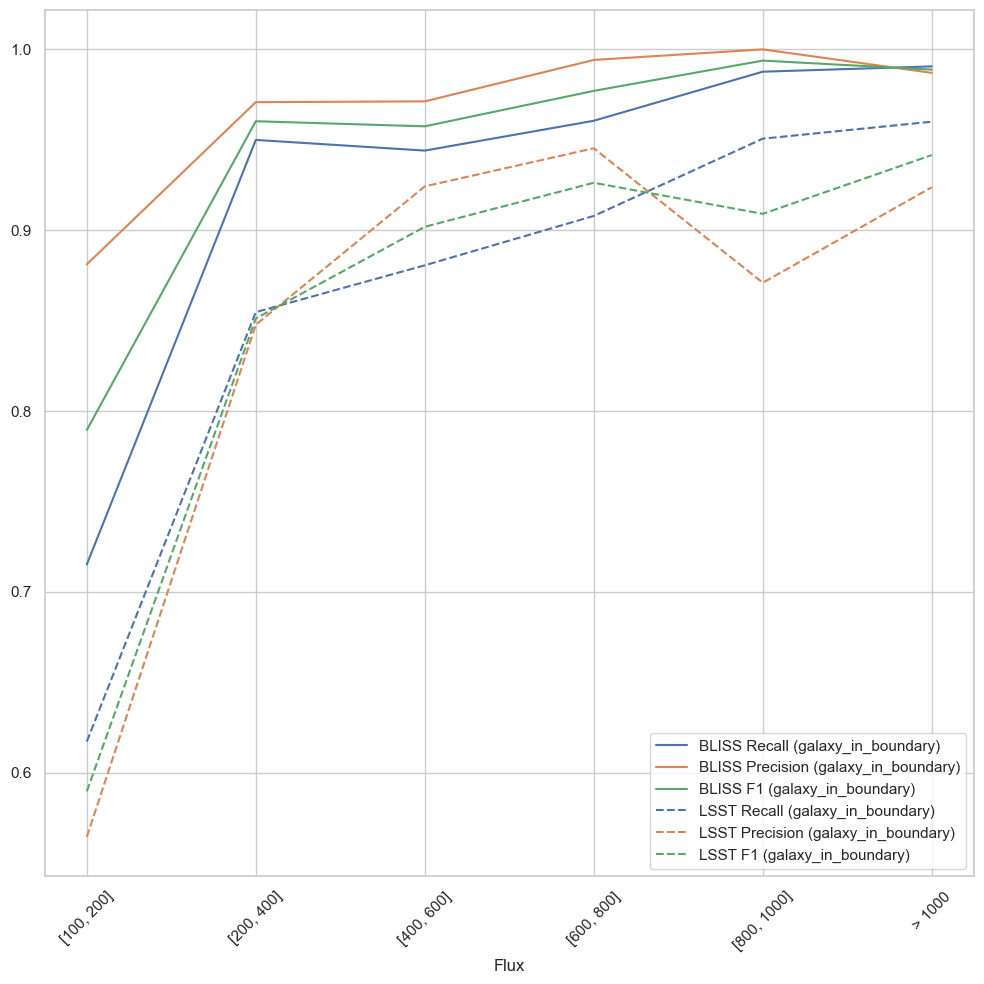

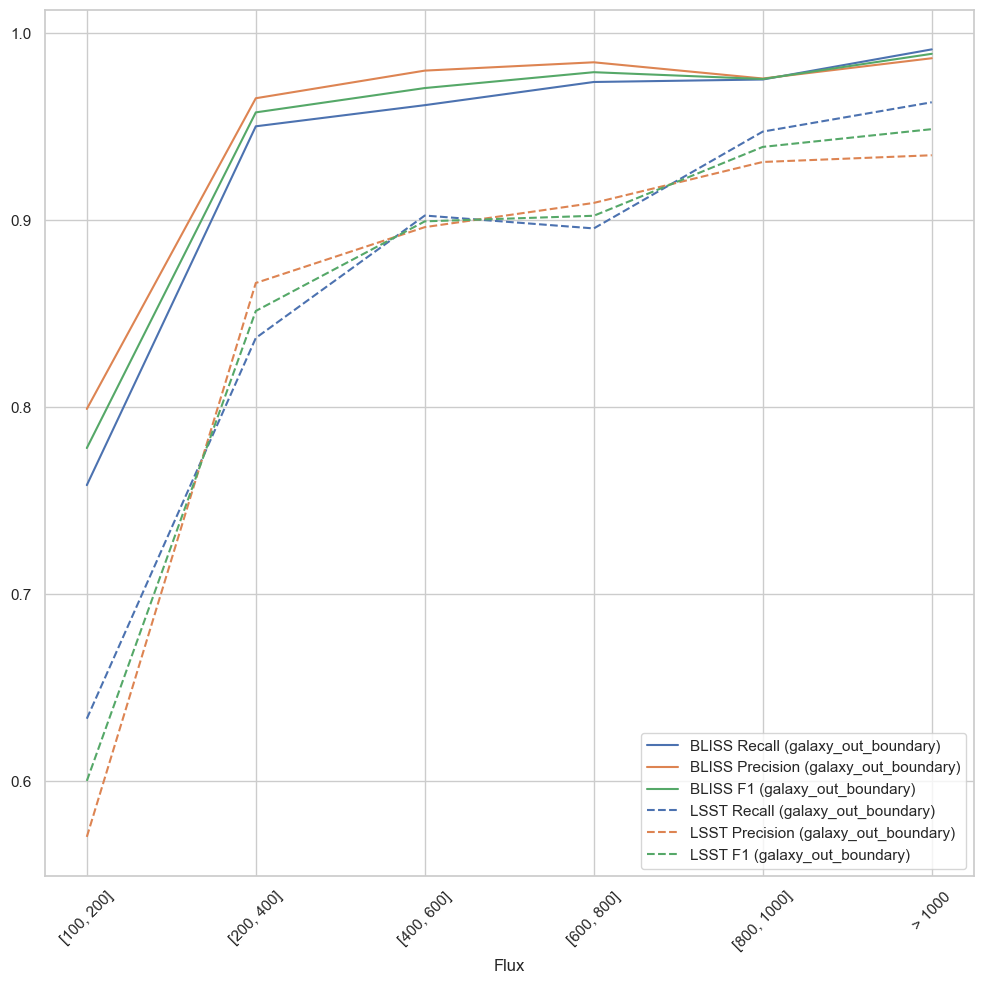

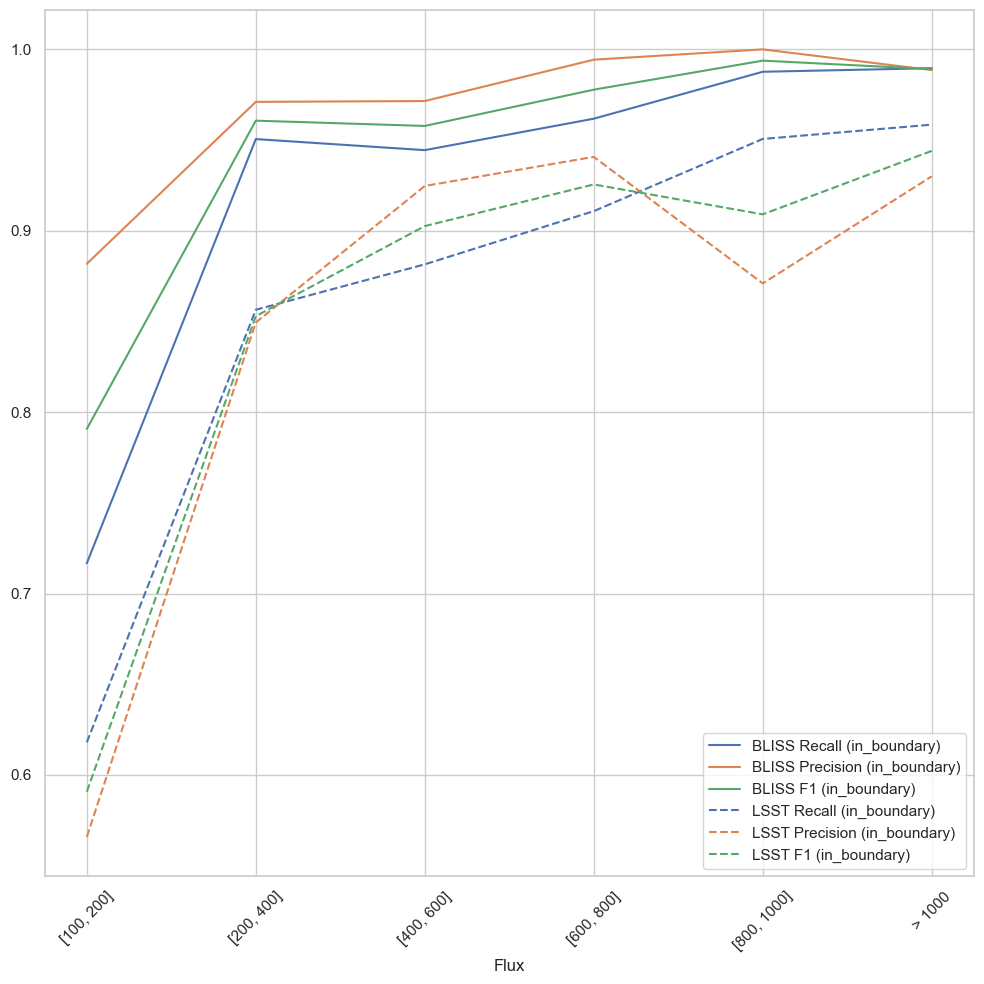

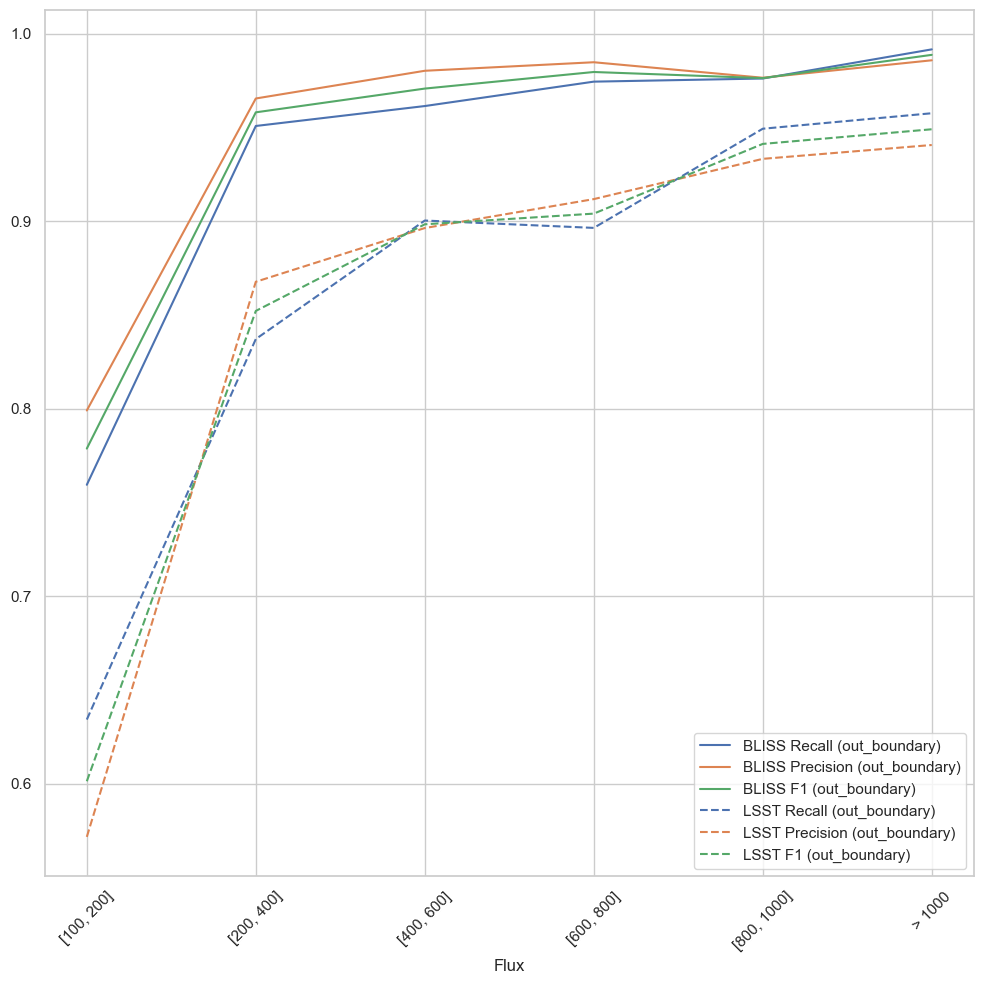

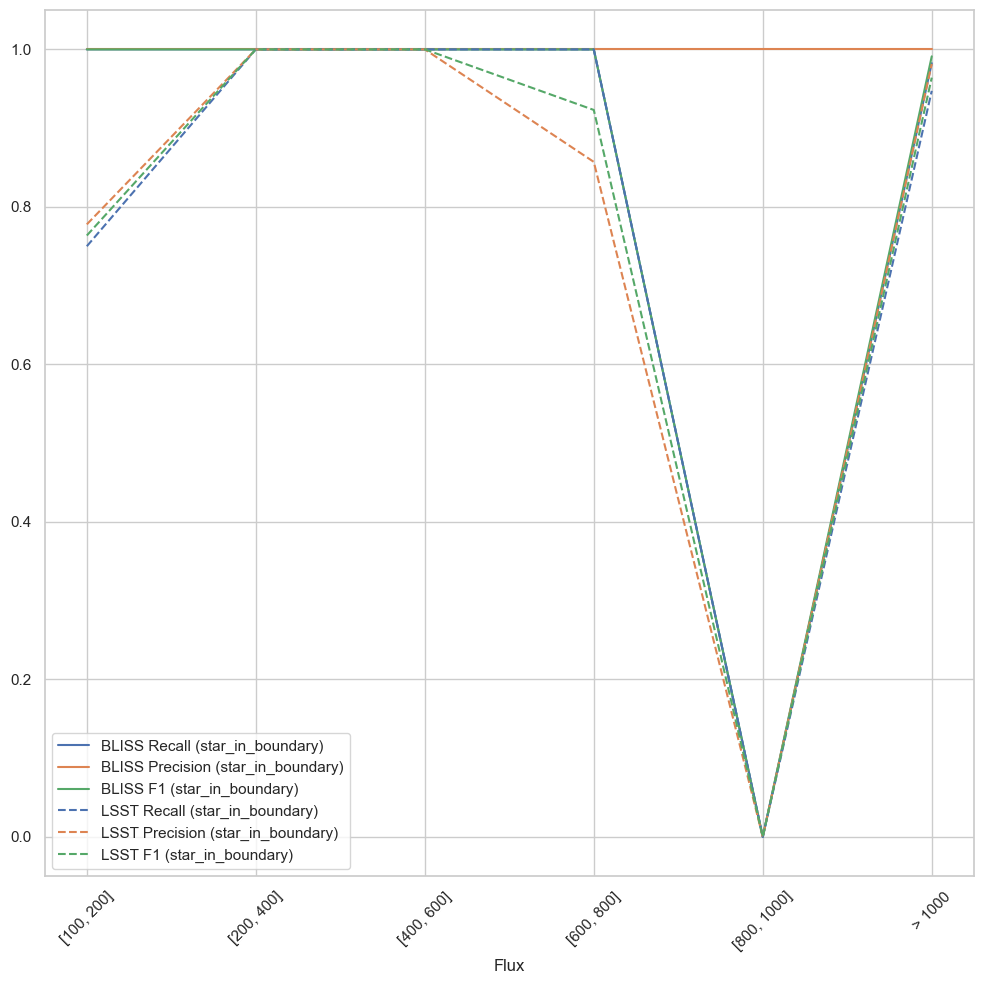

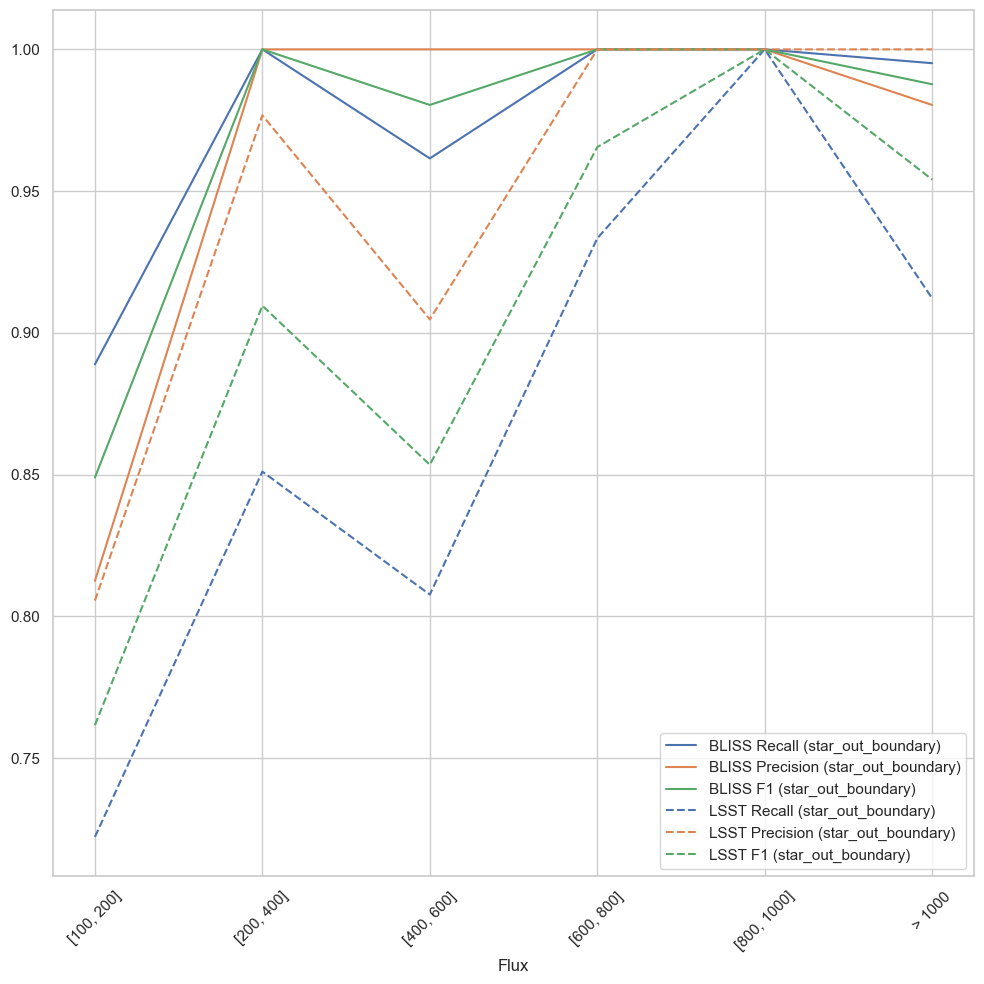

In [11]:
for k, v in bliss_metrics.items():
    flux_bin_cutoffs = v.bin_cutoffs
    postfix_str = v.postfix_str
    fig, ax = plot(bliss_results[f"detection_recall{postfix_str}"],
                    bliss_results[f"detection_precision{postfix_str}"],
                    bliss_results[f"detection_f1{postfix_str}"],
                    lsst_results[f"detection_recall{postfix_str}"],
                    lsst_results[f"detection_precision{postfix_str}"],
                    lsst_results[f"detection_f1{postfix_str}"],
                    flux_bin_cutoffs=flux_bin_cutoffs,
                    postfix_str=postfix_str,
                    model_name_1="BLISS",
                    model_name_2="LSST")
    
    fig.show()